# MIDI to RNN Input data treatment

This script was implemented to transform the pre-treated midi data to value arrays that can be served as input for the RNN training.

In [1]:
import pretty_midi
import numpy as np
import pandas as pd
import glob
import json

## MIDI data attributes analysis

In [2]:
midi_files = glob.glob(r"..\midi\treated_midi\*")
midi_file = pretty_midi.PrettyMIDI(midi_files[0])

instrument = midi_file.instruments[0]
print(pretty_midi.program_to_instrument_name(instrument.program))

note = instrument.notes[0]
print(note)

Acoustic Grand Piano
Note(start=0.000000, end=0.136364, pitch=76, velocity=60)


Looking at the previous snippet, the Note class has four attributes:
* **start**: time when the note starts (in seconds)
* **end**: time when the note ends (in seconds)
* **pitch**: pitch of the note (can be associated with the piano key)
* **velocity**: information on the volume of the note - during pre-treatment all notes were set with velocity of 60.

We can disconsider the velocity information, as it has no relevant information for the structure of the song.

Firstly, the data can be moved to an dictionary of dataframes, in which every single dataframe corresponds to a song.

In [3]:
data_dict = {}
for midi_file in midi_files:
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    song_dict = {
        "start": [],
        "end": [],
        "pitch": [],
    }
    for note in midi_data.instruments[0].notes:
        song_dict["start"].append(note.start)
        song_dict["end"].append(note.end)
        song_dict["pitch"].append(note.pitch)
    data_dict[midi_file.split("\\")[-1].split(".")[0]] = pd.DataFrame(song_dict).sort_values(by=['start', 'end'], ignore_index=True)

dict_key = list(data_dict.keys())[0]
print(f'{dict_key}\n{"-"*40}\n{data_dict[dict_key]}')

160_EIGHTMEASURE_EXERCISES_NO_1
----------------------------------------
         start        end  pitch
0     0.000000   0.136364     76
1     0.000000   0.545455     60
2     0.000000   0.545455     67
3     0.136364   0.272727     79
4     0.272727   0.409091     77
..         ...        ...    ...
147  15.818182  15.954545     72
148  15.954545  16.090909     76
149  16.090909  16.227273     79
150  16.227273  16.363636     84
151  16.363636  16.636364     72

[152 rows x 3 columns]


The informations of 'start' and 'end' of when the note is active can be changed to the duration and how "far" the next note is, to be a metric that is more uniform in the set.

In [4]:
for song in data_dict.values():
    song['duration'] = song['end'] - song['start']

    time_to_next = []
    for note_idx in range(song.shape[0]):
        if note_idx == (song.shape[0]-1):
            value = 0
        else:
            value = song.at[note_idx+1, 'start'] - song.at[note_idx, 'start']
        time_to_next.append(value)
    song['time_to_next'] = time_to_next

dict_key = list(data_dict.keys())[0]
print(f'{dict_key}\n{"-"*40}\n{data_dict[dict_key]}')

160_EIGHTMEASURE_EXERCISES_NO_1
----------------------------------------
         start        end  pitch  duration  time_to_next
0     0.000000   0.136364     76  0.136364      0.000000
1     0.000000   0.545455     60  0.545455      0.000000
2     0.000000   0.545455     67  0.545455      0.136364
3     0.136364   0.272727     79  0.136364      0.136364
4     0.272727   0.409091     77  0.136364      0.136364
..         ...        ...    ...       ...           ...
147  15.818182  15.954545     72  0.136364      0.136364
148  15.954545  16.090909     76  0.136364      0.136364
149  16.090909  16.227273     79  0.136364      0.136364
150  16.227273  16.363636     84  0.136364      0.136364
151  16.363636  16.636364     72  0.272727      0.000000

[152 rows x 5 columns]


## Metrics before treatment

In [5]:
print(f"Number of songs: {len(data_dict.keys())}\n")

Number of songs: 702



About number of notes per song:
count      702.000000
mean      1135.850427
std       1299.040192
min         55.000000
25%        372.250000
50%        667.500000
75%       1397.500000
max      10503.000000
dtype: float64


<AxesSubplot:title={'center':'Notes per track'}>

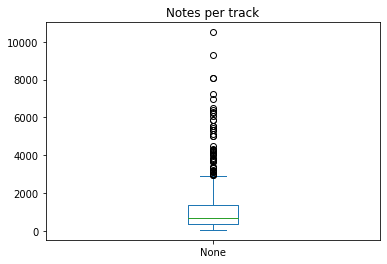

In [6]:

number_of_notes_per_song = pd.Series([df.shape[0] for df in data_dict.values()])
print("About number of notes per song:")
print(number_of_notes_per_song.describe())
number_of_notes_per_song.plot.box(title='Notes per track')


About note duration (in seconds):
count    797367.000000
mean          0.415639
std           0.475598
min           0.002273
25%           0.168182
50%           0.250000
75%           0.500000
max          32.000000
dtype: float64


<AxesSubplot:title={'center':'Note duration'}>

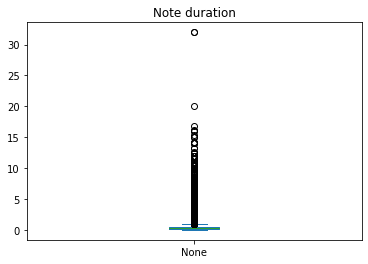

In [7]:

note_duration = pd.Series(dtype="float64")
for song in data_dict.values():
    note_duration = pd.concat([note_duration, song['duration']])
print("\nAbout note duration (in seconds):")
print(note_duration.describe())
note_duration.plot.box(title='Note duration')


About time to next note (in seconds):
count    797367.000000
mean          0.130528
std           0.235267
min           0.000000
25%           0.000000
50%           0.000000
75%           0.206818
max          41.022727
dtype: float64


<AxesSubplot:title={'center':'Time to Next'}>

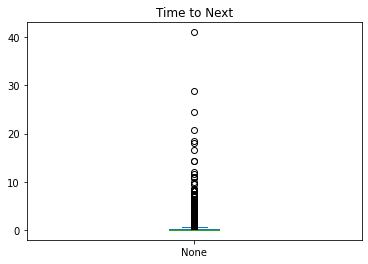

In [8]:
time_to_next = pd.Series(dtype="float64")
for song in data_dict.values():
    time_to_next = pd.concat([time_to_next, song['time_to_next']])
print("\nAbout time to next note (in seconds):")
print(time_to_next.describe())
time_to_next.plot.box(title='Time to Next')


About note pitch:
count    797367.000000
mean         63.200359
std          12.086736
min          17.000000
25%          55.000000
50%          63.000000
75%          72.000000
max         105.000000
dtype: float64


<AxesSubplot:title={'center':'Pitch'}>

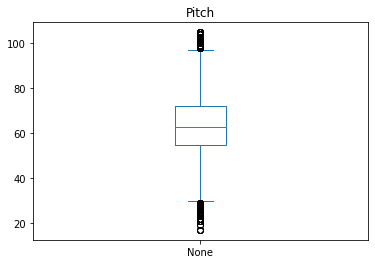

In [9]:
pitch_stats = pd.Series(dtype="float64")
for song in data_dict.values():
    pitch_stats = pd.concat([pitch_stats, song['pitch']])
print("\nAbout note pitch:")
print(pitch_stats.describe())
pitch_stats.plot.box(title='Pitch')

## Data Treatment

### Pitch treatment

As seen in previous snippet, the pitch of the notes vary from 17 to 105 in value, which can be translated from 21.83 Hz to 3520 Hz.
In a regular piano, the note of 21.83Hz is not achievable. The piano notes only start from 27.50Hz, which is the note A0, in MIDI pitch value of 21.
Having this in mind we can remove all notes under the pitch value of 21.

The max pitch value of 105 (or A7, 3520Hz) is valid for piano, so we don't need to trim in the high-pitch side.

In [10]:
removed_notes = 0
for song in data_dict.values():
    removed_notes += song[song['pitch'] < 21].shape[0]
    song.drop(song[song['pitch'] < 21].index, inplace=True)

min_pitch, max_pitch = np.inf , 0

for song in data_dict.values():
    min_pitch = min(min_pitch, song['pitch'].min())
    max_pitch = max(max_pitch, song['pitch'].max())

print(f'Removed {removed_notes} notes.\nPitch\nMin: {min_pitch}\tMax: {max_pitch}')
    

Removed 6 notes.
Pitch
Min: 21	Max: 105


After removing invalid pitch values, the values can be normalized between the min and max values.

In [11]:
def normalizePitch(og_pitch):
    return (og_pitch - 21) / (105 - 21)

def originalPitch(normalized_pitch):
    return normalized_pitch * (105 - 21) + 21

for song in data_dict.values():
    song['pitch'] = normalizePitch(song['pitch'])

In [12]:
dict_key = list(data_dict.keys())[0]
print(f'{dict_key}\n{"-"*40}\n{data_dict[dict_key]}')

160_EIGHTMEASURE_EXERCISES_NO_1
----------------------------------------
         start        end     pitch  duration  time_to_next
0     0.000000   0.136364  0.654762  0.136364      0.000000
1     0.000000   0.545455  0.464286  0.545455      0.000000
2     0.000000   0.545455  0.547619  0.545455      0.136364
3     0.136364   0.272727  0.690476  0.136364      0.136364
4     0.272727   0.409091  0.666667  0.136364      0.136364
..         ...        ...       ...       ...           ...
147  15.818182  15.954545  0.607143  0.136364      0.136364
148  15.954545  16.090909  0.654762  0.136364      0.136364
149  16.090909  16.227273  0.690476  0.136364      0.136364
150  16.227273  16.363636  0.750000  0.136364      0.136364
151  16.363636  16.636364  0.607143  0.272727      0.000000

[152 rows x 5 columns]


### Note duration

As some of the notes stay on for far more than most of the other notes, these can be trimmed to have a more uniform selection of notes.

In [13]:
max_duration = 7 #arbitrarily chosen 5s as max duration
min_duration = note_duration.quantile(.01)
print(f"Duration trimming:\nMax: {max_duration:.2f}s\tMin: {min_duration:.2f} s")

removed_notes = 0
for song in data_dict.values():
    removed_notes += song[song['duration'] < min_duration].shape[0] + song[song['duration'] > max_duration].shape[0]
    song.drop(song[song['duration'] < min_duration].index, inplace=True)
    song.drop(song[song['duration'] > max_duration].index, inplace=True)

note_duration = pd.Series(dtype="float64")
for song in data_dict.values():
    note_duration = pd.concat([note_duration, song['duration']])
print(f"Removed {removed_notes} notes")

Duration trimming:
Max: 7.00s	Min: 0.07 s
Removed 7450 notes


## Distance between notes

As seen in the metrics, there are some big gaps between one note and another, first we can check in which songs and at which timemark they happen.

In [14]:

for song_name, song_data in data_dict.items():
    for _, note in song_data.iterrows():
        if note['time_to_next'] > 9:
            print(f"{song_name}: {note.time_to_next:.2f}s at {int(note.start//60)}:{int(note.start)%60:02d}s")


BRAHMS_HORN_TRIO: 20.83s at 15:51s
BRAHMS_HORN_TRIO: 11.67s at 21:27s
DER_HIRT_AUF_DEM_FELSEN: 18.52s at 8:57s
DOUMKA: 10.00s at 7:46s
NACHT_UND_TRUME: 18.00s at 2:06s
NHE_DES_GELIEBTEN: 10.80s at 2:27s
PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO: 14.32s at 5:10s
PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO: 41.02s at 6:50s
PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO: 16.59s at 9:20s
PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO: 14.32s at 10:30s
PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO: 24.55s at 12:10s
PIANO_TRIO_OPUS_11_3RD_MOVEMENT: 28.77s at 0:52s
ROMANCE: 11.00s at 2:43s
ROMANCE: 9.50s at 2:55s
RVERIE: 10.91s at 2:38s


Listening to some of the shown songs, these gaps seem to mean a new "movement" in the song, that may be considered a different track. So to avoid these big gaps between songs, the songs can be splitted where the gap occurs.

In [15]:
data_dict_copy = data_dict.copy()
for song_name, song_data in data_dict_copy.items():
    split_points = []
    for note_idx, note in song_data.iterrows():
        if note.time_to_next > 9:
            split_points.append(note_idx+1)

    if len(split_points):
        split_points.append(song_data.shape[0])
        data_dict.pop(song_name)
        print(f"Removed {song_name} from data dictionary:")
        start_point = 0
        subtrack_cnt = 0
        for split_point in split_points:
            subtrack_cnt += 1
            song_data.loc[split_point-1, "time_to_next"] = 0
            data_dict.update({f"{song_name}_SBTRK{subtrack_cnt}": song_data.iloc[start_point:split_point, :]})
            print(f"\tNew subtrack {song_name}_SBTRK{subtrack_cnt} added.")
            start_point = split_point
        print()

Removed BRAHMS_HORN_TRIO from data dictionary:
	New subtrack BRAHMS_HORN_TRIO_SBTRK1 added.
	New subtrack BRAHMS_HORN_TRIO_SBTRK2 added.
	New subtrack BRAHMS_HORN_TRIO_SBTRK3 added.

Removed DER_HIRT_AUF_DEM_FELSEN from data dictionary:
	New subtrack DER_HIRT_AUF_DEM_FELSEN_SBTRK1 added.
	New subtrack DER_HIRT_AUF_DEM_FELSEN_SBTRK2 added.

Removed DOUMKA from data dictionary:
	New subtrack DOUMKA_SBTRK1 added.
	New subtrack DOUMKA_SBTRK2 added.

Removed NACHT_UND_TRUME from data dictionary:
	New subtrack NACHT_UND_TRUME_SBTRK1 added.
	New subtrack NACHT_UND_TRUME_SBTRK2 added.

Removed NHE_DES_GELIEBTEN from data dictionary:
	New subtrack NHE_DES_GELIEBTEN_SBTRK1 added.
	New subtrack NHE_DES_GELIEBTEN_SBTRK2 added.

Removed PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO from data dictionary:
	New subtrack PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO_SBTRK1 added.
	New subtrack PIANO_CONCERTO_NO_3_IN_C_MINOR_1ST_MOVEMENT_ALLEGRO_CON_BRIO_SBTRK2 added.
	New 

## New Metrics after treatment

In [16]:
print(f"Number of songs: {len(data_dict.keys())}\n")

Number of songs: 717




About note duration (in seconds):
count    789917.000000
mean          0.416346
std           0.448034
min           0.065909
25%           0.170455
50%           0.250000
75%           0.500000
max           7.000000
dtype: float64


<AxesSubplot:title={'center':'Note duration'}>

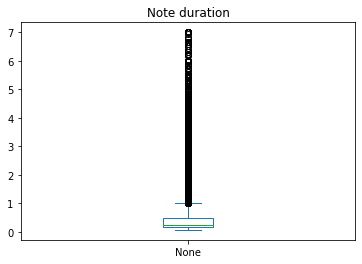

In [17]:
note_duration = pd.Series(dtype="float64")
for song in data_dict.values():
    note_duration = pd.concat([note_duration, song['duration']])
print("\nAbout note duration (in seconds):")
print(note_duration.describe())
note_duration.plot.box(title='Note duration')


About time to next note (in seconds):
count    789917.000000
mean          0.130800
std           0.218353
min           0.000000
25%           0.000000
50%           0.000000
75%           0.209091
max           8.143182
dtype: float64


<AxesSubplot:title={'center':'Time to Next'}>

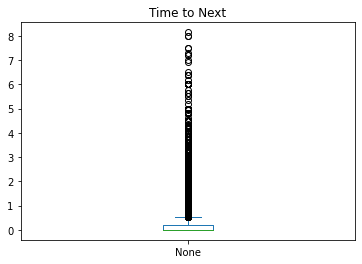

In [18]:
time_to_next = pd.Series(dtype="float64")
for song in data_dict.values():
    time_to_next = pd.concat([time_to_next, song['time_to_next']])
print("\nAbout time to next note (in seconds):")
print(time_to_next.describe())
time_to_next.plot.box(title='Time to Next')


About note pitch:
count    789917.000000
mean          0.501869
std           0.143614
min           0.000000
25%           0.404762
50%           0.500000
75%           0.607143
max           1.000000
dtype: float64


<AxesSubplot:title={'center':'Pitch'}>

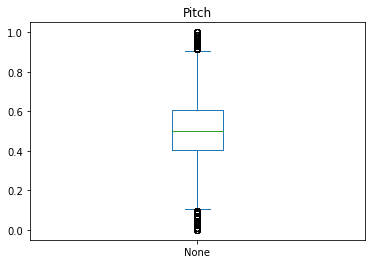

In [19]:
pitch_stats = pd.Series(dtype="float64")
for song in data_dict.values():
    pitch_stats = pd.concat([pitch_stats, song['pitch']])
print("\nAbout note pitch:")
print(pitch_stats.describe())
pitch_stats.plot.box(title='Pitch')

## Storing the data

Lastly, the data can be stored as a JSON file.

In [20]:
with open('.\\data\\treated_data.json', 'w+') as f:
    data_to_store = {}
    for song in data_dict:
        data_to_store.update({song: data_dict[song].to_json()})
    json.dump(data_to_store, f, indent=2)